In [1]:
import numpy as np
from sklearn.neighbors import KernelDensity

X = np.array([[-1, -1], [-2, -1], [-3, -2], [1, 1], [2, 1], [3, 2]])
kde = KernelDensity(kernel="gaussian", bandwidth=0.2).fit(X)
kde.score_samples(X)

array([-0.41075698, -0.41075698, -0.41076071, -0.41075698, -0.41075698,
       -0.41076071])

best bandwidth: 3.79269019073225


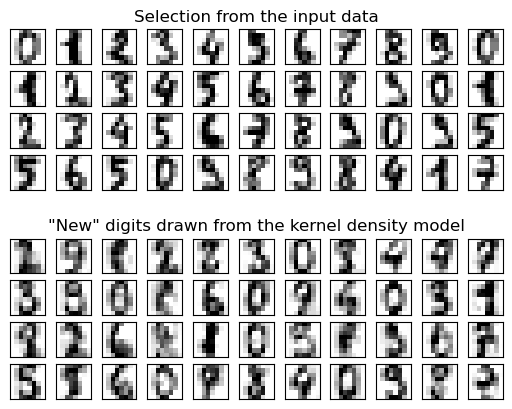

In [2]:
import matplotlib.pyplot as plt
import numpy as np

from sklearn.datasets import load_digits
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# 加载手写数字数据
digits = load_digits()

# 将 64 维数据降维到 15 维
pca = PCA(n_components=15, whiten=False)
data = pca.fit_transform(digits.data)

# 使用 grid-search 交叉验证优化 bandwidth
params = {"bandwidth": np.logspace(-1, 1, 20)}
grid = GridSearchCV(KernelDensity(), params)
grid.fit(data)

print("best bandwidth: {0}".format(grid.best_estimator_.bandwidth))

# 使用最佳估计器计算核密度估计
kde = grid.best_estimator_

# sample 44 new points from the data
new_data = kde.sample(44, random_state=0)
new_data = pca.inverse_transform(new_data)

# turn data into a 4x11 grid
new_data = new_data.reshape((4, 11, -1))
real_data = digits.data[:44].reshape((4, 11, -1))

# plot real digits and resampled digits
fig, ax = plt.subplots(9, 11, subplot_kw=dict(xticks=[], yticks=[]))
for j in range(11):
    ax[4, j].set_visible(False)
    for i in range(4):
        im = ax[i, j].imshow(
            real_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)
        im = ax[i + 5, j].imshow(
            new_data[i, j].reshape((8, 8)), cmap=plt.cm.binary, interpolation="nearest"
        )
        im.set_clim(0, 16)

ax[0, 5].set_title("Selection from the input data")
ax[5, 5].set_title('"New" digits drawn from the kernel density model')

plt.show()

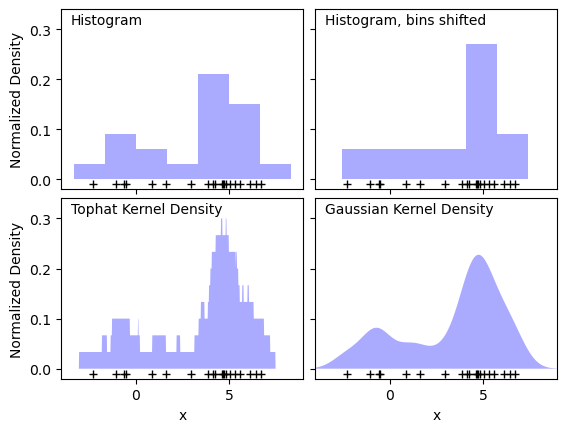

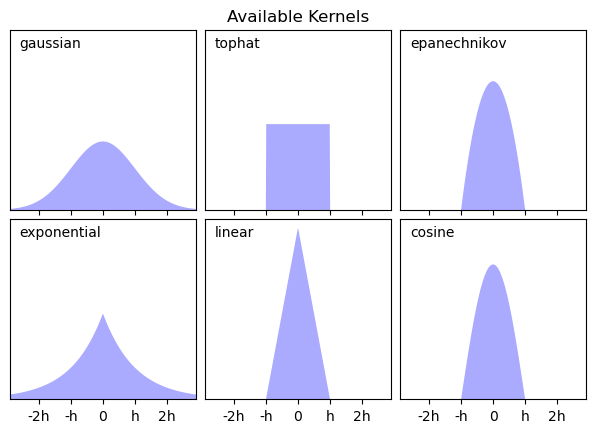

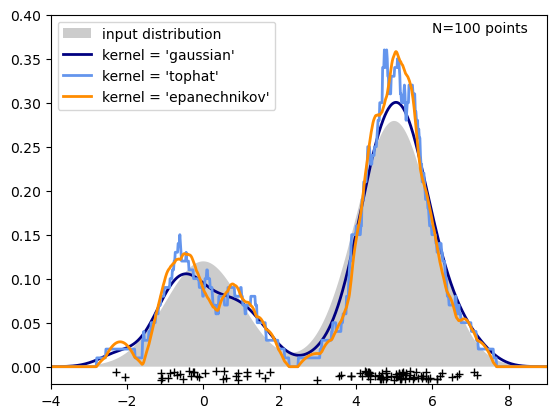

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

from sklearn.neighbors import KernelDensity

# ----------------------------------------------------------------------
# Plot the progression of histograms to kernels
np.random.seed(1)
N = 20
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]
X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]
bins = np.linspace(-5, 10, 10)

fig, ax = plt.subplots(2, 2, sharex=True, sharey=True)
fig.subplots_adjust(hspace=0.05, wspace=0.05)

# histogram 1
ax[0, 0].hist(X[:, 0], bins=bins, fc="#AAAAFF", density=True)
ax[0, 0].text(-3.5, 0.31, "Histogram")

# histogram 2
ax[0, 1].hist(X[:, 0], bins=bins + 0.75, fc="#AAAAFF", density=True)
ax[0, 1].text(-3.5, 0.31, "Histogram, bins shifted")

# tophat KDE
kde = KernelDensity(kernel="tophat", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 0].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 0].text(-3.5, 0.31, "Tophat Kernel Density")

# Gaussian KDE
kde = KernelDensity(kernel="gaussian", bandwidth=0.75).fit(X)
log_dens = kde.score_samples(X_plot)
ax[1, 1].fill(X_plot[:, 0], np.exp(log_dens), fc="#AAAAFF")
ax[1, 1].text(-3.5, 0.31, "Gaussian Kernel Density")

for axi in ax.ravel():
    axi.plot(X[:, 0], np.full(X.shape[0], -0.01), "+k")
    axi.set_xlim(-4, 9)
    axi.set_ylim(-0.02, 0.34)

for axi in ax[:, 0]:
    axi.set_ylabel("Normalized Density")

for axi in ax[1, :]:
    axi.set_xlabel("x")

# ----------------------------------------------------------------------
# Plot all available kernels
X_plot = np.linspace(-6, 6, 1000)[:, None]
X_src = np.zeros((1, 1))

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True)
fig.subplots_adjust(left=0.05, right=0.95, hspace=0.05, wspace=0.05)


def format_func(x, loc):
    if x == 0:
        return "0"
    elif x == 1:
        return "h"
    elif x == -1:
        return "-h"
    else:
        return "%ih" % x


for i, kernel in enumerate(
        ["gaussian", "tophat", "epanechnikov", "exponential", "linear", "cosine"]
):
    axi = ax.ravel()[i]
    log_dens = KernelDensity(kernel=kernel).fit(X_src).score_samples(X_plot)
    axi.fill(X_plot[:, 0], np.exp(log_dens), "-k", fc="#AAAAFF")
    axi.text(-2.6, 0.95, kernel)

    axi.xaxis.set_major_formatter(plt.FuncFormatter(format_func))
    axi.xaxis.set_major_locator(plt.MultipleLocator(1))
    axi.yaxis.set_major_locator(plt.NullLocator())

    axi.set_ylim(0, 1.05)
    axi.set_xlim(-2.9, 2.9)

ax[0, 1].set_title("Available Kernels")

# Plot a 1D density example
N = 100
np.random.seed(1)
X = np.concatenate(
    (np.random.normal(0, 1, int(0.3 * N)), np.random.normal(5, 1, int(0.7 * N)))
)[:, np.newaxis]

X_plot = np.linspace(-5, 10, 1000)[:, np.newaxis]

true_dens = 0.3 * norm(0, 1).pdf(X_plot[:, 0]) + 0.7 * norm(5, 1).pdf(X_plot[:, 0])

fig, ax = plt.subplots()
ax.fill(X_plot[:, 0], true_dens, fc="black", alpha=0.2, label="input distribution")
colors = ["navy", "cornflowerblue", "darkorange"]
kernels = ["gaussian", "tophat", "epanechnikov"]
lw = 2

for color, kernel in zip(colors, kernels):
    kde = KernelDensity(kernel=kernel, bandwidth=0.5).fit(X)
    log_dens = kde.score_samples(X_plot)
    ax.plot(
        X_plot[:, 0],
        np.exp(log_dens),
        color=color,
        lw=lw,
        linestyle="-",
        label="kernel = '{0}'".format(kernel),
    )

ax.text(6, 0.38, "N={0} points".format(N))

ax.legend(loc="upper left")
ax.plot(X[:, 0], -0.005 - 0.01 * np.random.random(X.shape[0]), "+k")

ax.set_xlim(-4, 9)
ax.set_ylim(-0.02, 0.4)
plt.show()